In [198]:
import pandas as pd
from scipy.stats import zscore

In [199]:
%matplotlib inline

In [200]:
df = pd.read_csv('df.csv', index_col=0)

In [202]:
df_small = df["2017-01":"2018-07"].drop(columns='ChainData')

In [215]:
df_small_diff = df_small.pct_change().rename(columns = lambda x: x + "_1")
df_small_diff_7 = df_small.pct_change(7).rename(columns = lambda x: x + "_7")
df_small_diff_28 = df_small.pct_change(28).rename(columns = lambda x: x + "_28")

In [216]:
df_small_all = pd.concat([df_small_diff, df_small_diff_7, df_small_diff_28 ], axis=1)

In [217]:
df_small_all["EtherReturn"] = df_small_diff.EtherPrice_1.shift(-1)

,EtherReturn
BlockCountRewards_7,-0.065445
Ethersupply_7,-0.062724
EnsRegistrations_1,-0.032338
BlockCountRewards_1,-0.027240
Uncles_7,-0.027108
BlockCountRewards_28,-0.025634
Ethersupply_28,-0.024034
NetworkHash_28,-0.023736
Uncles_1,-0.015252
TransactionFee_1,-0.012749


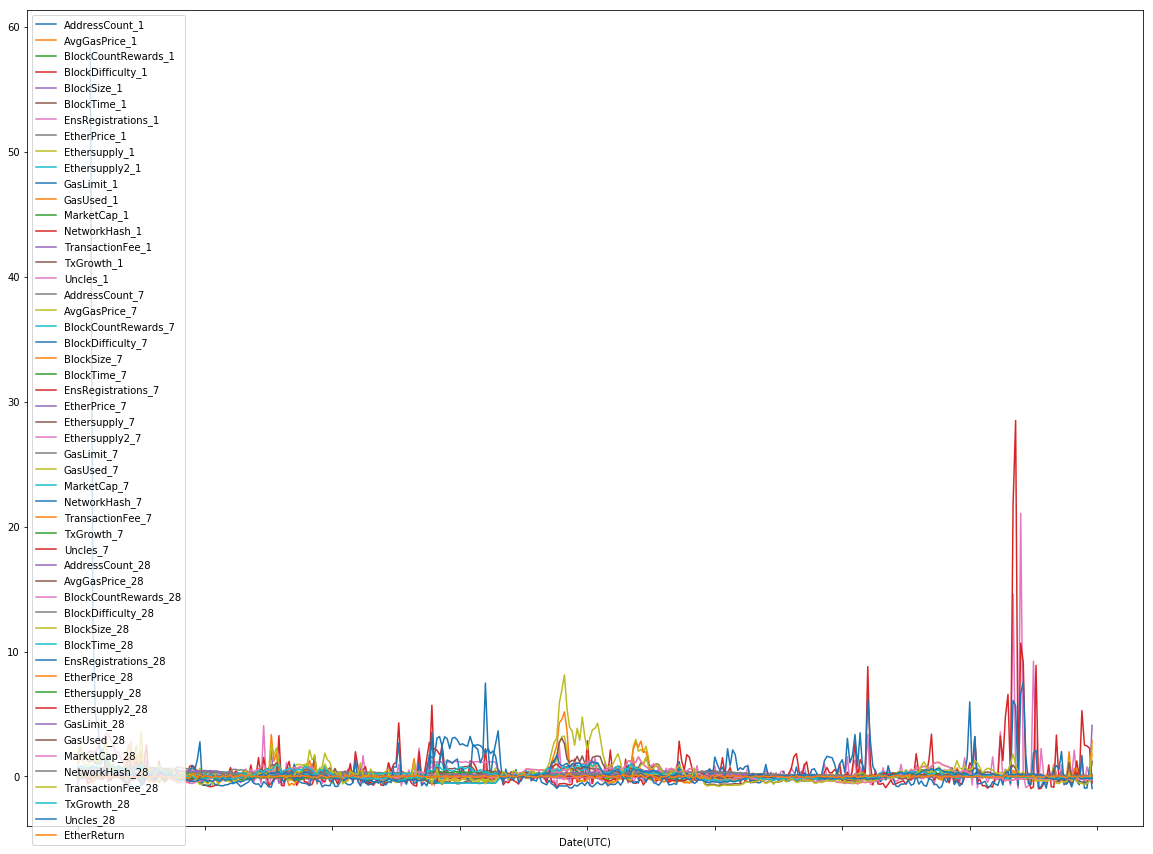

In [320]:
df_zscore = df_small_all #(df_small_all - df_small_all.mean())/df_small_all.std()
df_zscore.plot(figsize=(20,15))
df_zscore.corr()[['EtherReturn']].sort_values('EtherReturn')

In [219]:
df_small_all = df_small_all.ffill().dropna()

In [248]:
y = df_small_all["EtherReturn"].values

In [249]:
X = df_small_all.drop(columns=["EtherReturn", "EnsRegistrations_28"]).values

In [349]:
# import machine learning algorithms
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [366]:
min_window = 28 * 6
learning_rate = 1.0
models = []
predictions = []
for idx in range(min_window, len(y)):
    #gb = GradientBoostingRegressor(n_estimators=100, learning_rate = learning_rate, max_features=3, max_depth = 3, random_state = idx)
    gb = RandomForestRegressor(random_state = idx)
    #gb = Lasso(random_state=idx)
    X_train_sub = X[idx-min_window:idx]
    y_train_sub = y[idx-min_window:idx]
    gb.fit(X_train_sub, y_train_sub)
    models.append(gb)
    predictions.append(gb.predict(X[idx:idx+1])[0])
    #print("Learning rate: ", learning_rate)
    #print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    

In [367]:
import numpy as np

In [368]:
res = pd.DataFrame({"y":y[min_window:], "y_hat":predictions}, index=df_small_all.index[min_window:])

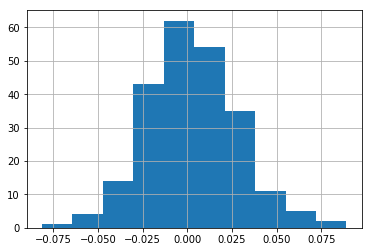

In [369]:
res.y_hat.hist()

count    231.000000
mean       0.027376
std        0.590805
min       -2.951625
25%       -0.139161
50%       -0.000069
75%        0.209318
max        2.663293
Name: pnl, dtype: float64

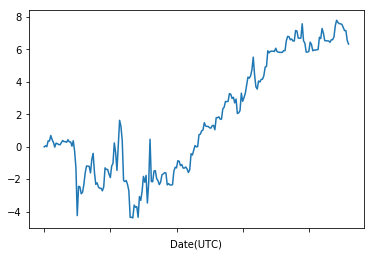

In [370]:
res["position"] = 1/(1+np.exp(-res.y_hat)) - 0.5
#res.loc[res.y_hat.abs() < res.y_hat.std(), "position"] = 0.0
# so that the chart is easy to interpret, sizing on average is 1 position

res["pnl"] = res.y * res.position * 1/res["position"].mean() 

res.pnl.cumsum().plot()
res.pnl.describe()

count    313.000000
mean       0.035990
std        0.591293
min       -3.638263
25%        0.000000
50%       -0.000000
75%        0.030454
max        5.837357
Name: pnl, dtype: float64

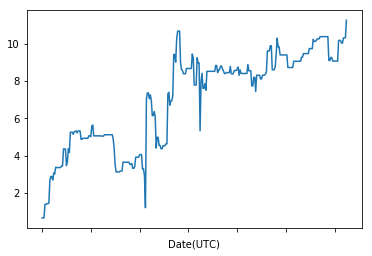

In [155]:
res["position"] = 1/(1+np.exp(-res.y_hat)) - 0.5
res.loc[res.y_hat.abs() < 0.5*res.y_hat.std(), "position"] = 0.0
# so that the chart is easy to interpret, sizing on average is 1 position

res["pnl"] = res.y * res.position * 1/res["position"].mean() 

res.pnl.cumsum().plot()
res.pnl.describe()